In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm


In [2]:
import py3utils as p3
import rf_utils as rfutils
import plotting as pplot

In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Source data

In [121]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'
response_type='dff'
fit_thr=0.5
do_spherical_correction=False

# Plotting params

In [122]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)


# Load data

In [123]:
sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


,animalid,session,fovnum
visual_area,,,
Li,17,17,17
Lm,18,18,18
V1,19,19,19


In [124]:
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001_fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [125]:
# Load RF fit params for good rois
# rfdata = rfutils.cycle_and_load(rf_meta, CELLS, reliable_only=True, 
#                         fit_desc=rf_fit_desc, traceid=traceid, verbose=False)
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = p3.add_rf_positions(rfdata)

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
Adding RF position info...


In [126]:
counts = rfdata.groupby(['visual_area', 'animalid', 'session', \
                         'fovnum', 'datakey', 'experiment'])['cell'].count().reset_index()
print(counts.groupby(['visual_area', 'experiment']).sum())

                        fovnum  cell
visual_area experiment              
Li          rfs              3    49
            rfs10           19   412
Lm          rfs             13   359
            rfs10            6    54
V1          rfs             16   637
            rfs10            9   633


In [127]:
rfdata.head()

,x0,y0,fwhm_x,fwhm_y,theta,r2,cell,datakey,animalid,session,...,minor_axis,anisotropy,theta_Mm_c,aniso_index,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,-0.359113,25.227100,39.363302,31.265255,5.491278,0.520312,115.0,20190522_JC089_fov1,JC089,20190522,...,13.304364,0.114657,-0.791907,0.048544,467.813699,203,801.465362,421,171.334638,709.786301
1,3.931988,24.304596,31.689496,36.726462,6.074524,0.559490,122.0,20190522_JC089_fov1,JC089,20190522,...,13.484892,0.073623,1.362135,0.070429,504.685714,219,856.67319,450,116.12681,672.914286
2,12.547553,2.575407,29.483275,25.960252,6.261067,0.529471,113.0,20190522_JC089_fov1,JC089,20190522,...,11.046916,0.063543,-0.022118,-0.060732,615.301761,267,711.990607,374,260.809393,562.298239
3,3.718242,11.808561,31.775266,30.710669,0.442568,0.767423,116.0,20190522_JC089_fov1,JC089,20190522,...,13.068370,0.017037,0.442568,-0.002444,566.907241,246,805.272798,423,167.527202,610.692759
4,8.476630,2.498789,38.655484,25.170942,0.701064,0.515310,145.0,20190522_JC089_fov1,JC089,20190522,...,10.711039,0.211269,0.701064,0.061281,705.177299,306,786.235616,413,186.564384,472.422701


## Compare rf-5 / rf-10

In [128]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [129]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir, 'rfs5_v_rfs10')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10


In [130]:
cells_w_both = pd.concat([g for (va, dk, ri), g in \
                rfdata.groupby(['visual_area', 'datakey', 'cell']) \
                if 'rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values])
cells_w_both.groupby(['experiment', 'visual_area']).count()

x0   y0  fwhm_x  fwhm_y  theta   r2  cell  datakey  \
experiment visual_area                                                        
rfs        Li            33   33      33      33     33   33    33       33   
           Lm            10   10      10      10     10   10    10       10   
           V1           200  200     200     200    200  200   200      200   
rfs10      Li            33   33      33      33     33   33    33       33   
           Lm            10   10      10      10     10   10    10       10   
           V1           200  200     200     200    200  200   200      200   

                        animalid  session  ...  minor_axis  anisotropy  \
experiment visual_area                     ...                           
rfs        Li                 33       33  ...          33          33   
           Lm                 10       10  ...          10          10   
           V1                200      200  ...         200         200   
rfs10      Li                 33       33  ...          33          33   
           Lm                 10       10  ...          10          10   
           V1                200      200  ...         200         200   

                        theta_Mm_c  aniso_index  fov_xpos  fov_xpos_pix  \
experiment visual_area                                                    
rfs        Li                   33           33        33            33   
           Lm                   10           10        10            10   
           V1                  200          200       200           200   
rfs10      Li                   33           33        33            33   
           Lm                   10           10        10            10   
           V1                  200          200       200           200   

                        fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
experiment visual_area                                          
rfs        Li                 33            33      33      33  
           Lm                 10            10      10      10  
           V1                200           200     200     200  
rfs10      Li                 33            33      33      33  
           Lm                 10            10      10      10  
           V1                200           200     200     200  

[6 rows x 32 columns]

In [131]:
cells_w_both.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'r2', 'cell', 'datakey',
       'animalid', 'session', 'fovnum', 'visual_area', 'experiment', 'std_x',
       'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy',
       'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy',
       'theta_Mm_c', 'aniso_index', 'fov_xpos', 'fov_xpos_pix', 'fov_ypos',
       'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

#### Correlation of metrics for rf-5 v rf-10

<IPython.core.display.Javascript object>


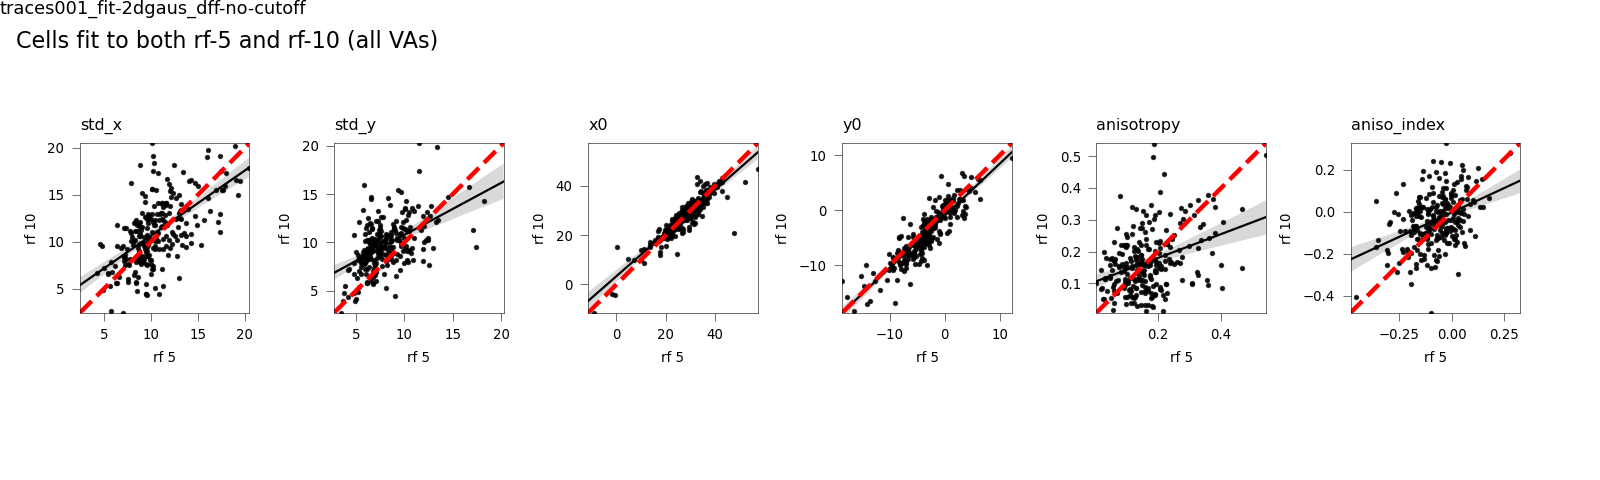

Wilcoxon paired test:
... param: std_x (p=0.02)
... param: std_y (p=0.00)
... param: y0 (p=0.00)
... param: aniso_index (p=0.00)
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10 allparams__cells_w_both


In [132]:
params_to_check = ['std_x', 'std_y', 'x0', 'y0', 'anisotropy', 'aniso_index']

fig, axn = pl.subplots(1, len(params_to_check), figsize=(10,3))
print("Wilcoxon paired test:")
for pi, par in enumerate(params_to_check):
    ax = axn[pi]
    ax.set_title(par,loc='left')
    v1 = cells_w_both[cells_w_both.experiment=='rfs'][par].values
    v2 = cells_w_both[cells_w_both.experiment=='rfs10'][par].values
    vmin = min([np.min(v1), np.min(v2)])
    vmax = max([np.max(v1), np.max(v2)])
    ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
    ax.set_aspect('equal')
    #ax.scatter(v1, v2, s=20, color=area_colors[va], marker='+', lw=0.5)
    sns.regplot(x=v1, y=v2, ax=ax, color='k', truncate=False,
                scatter_kws={'s':2}, line_kws={'lw': 1})
    ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=2)
    # Annotate w stats
    stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
    if p<0.05:
        print("... param: %s (p=%.2f)" % (par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)    
fig.text(0.01, 0.9, 'Cells fit to both rf-5 and rf-10 (all VAs)', fontsize=10)

p3.label_figure(fig, data_id)
figname = 'allparams__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


#### Split by VA

<IPython.core.display.Javascript object>


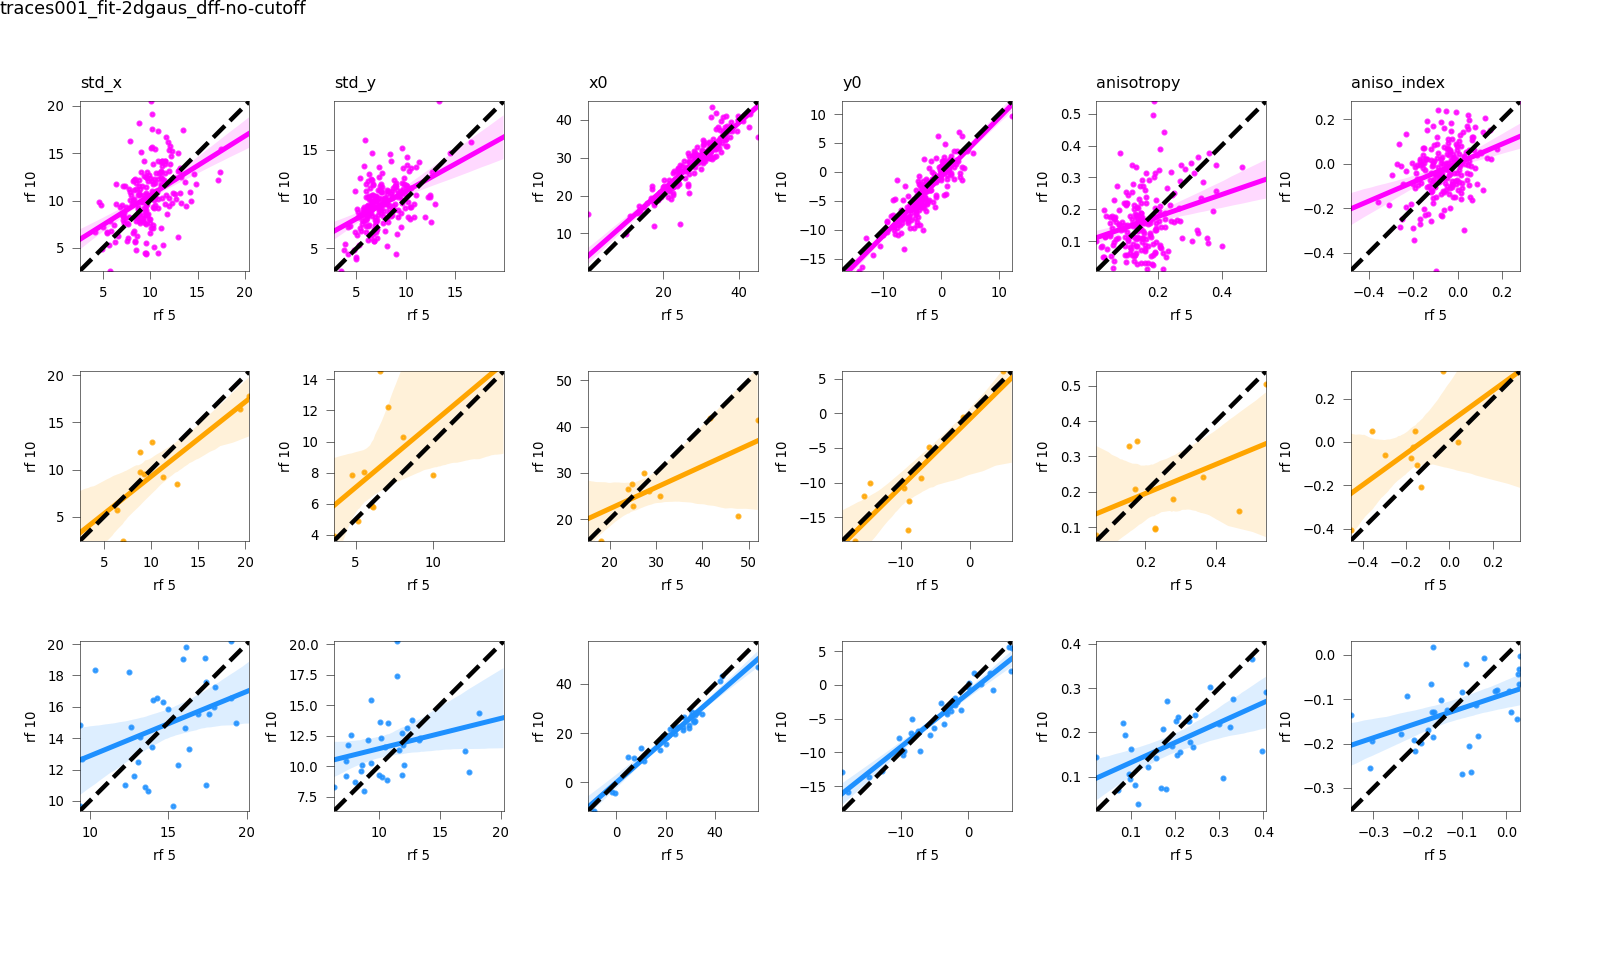

...[V1] param: std_x (p=0.00)
...[V1] param: std_y (p=0.00)
...[Li] param: x0 (p=0.00)
...[V1] param: x0 (p=0.00)
...[V1] param: y0 (p=0.00)
...[Lm] param: aniso_index (p=0.02)
...[V1] param: aniso_index (p=0.00)
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10 allparams_byVA__cells_w_both


In [133]:
params_to_check = ['std_x', 'std_y', 'x0', 'y0', 'anisotropy', 'aniso_index']
fig, axn = pl.subplots(3, len(params_to_check), figsize=(10,6))
for pi, par in enumerate(params_to_check):
    for va, vg in cells_w_both.groupby(['visual_area']):
        vi = visual_areas.index(va)
        ax = axn[vi, pi]
        if vi==0:
            ax.set_title(par,loc='left')
        v1 = vg[vg.experiment=='rfs'][par].values
        v2 = vg[vg.experiment=='rfs10'][par].values
        vmin = min([np.min(v1), np.min(v2)])
        vmax = max([np.max(v1), np.max(v2)])
        ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
        ax.set_aspect('equal')
        #ax.scatter(v1, v2, s=5, color=area_colors[va])
        sns.regplot(x=v1, y=v2, ax=ax, color=area_colors[va], truncate=False,
                    scatter_kws={'s':3})
        ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
        ax.plot([vmin, vmax], [vmin, vmax], 'k--', lw=2)
        # Annotate w stats
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if p<0.05:
            print("...[%s] param: %s (p=%.2f)" % (va, par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)
p3.label_figure(fig, data_id)

figname = 'allparams_byVA__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


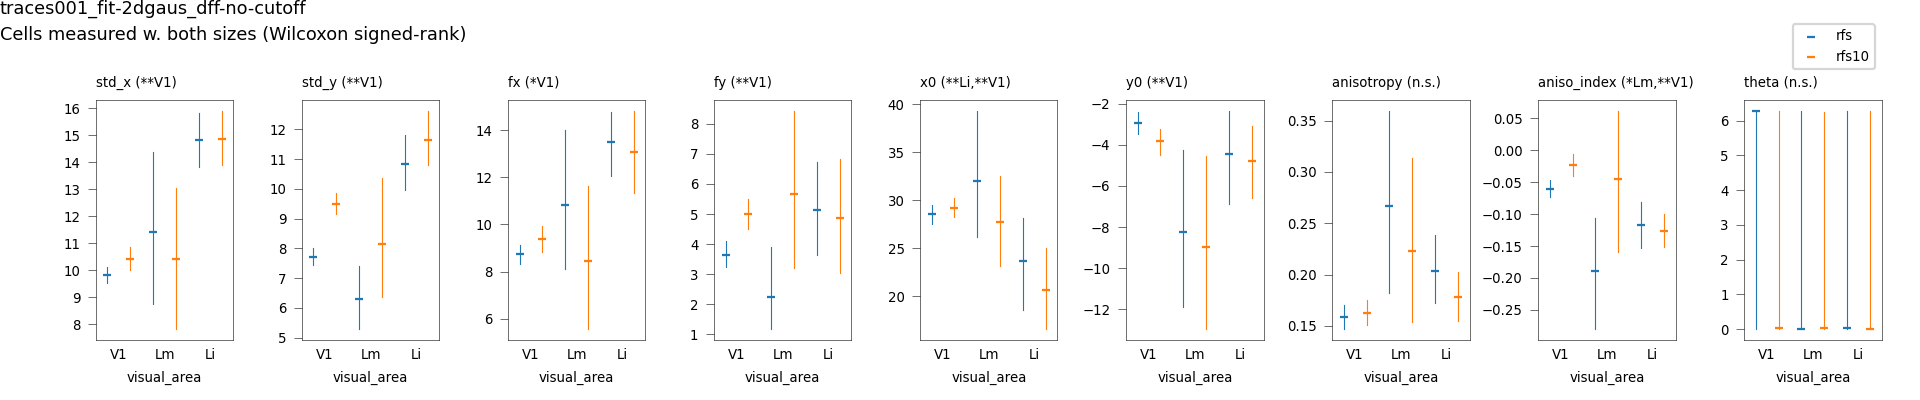

[std_x] ----------------------
[std_y] ----------------------
[fx] ----------------------
[fy] ----------------------
[x0] ----------------------
[y0] ----------------------
[anisotropy] ----------------------
[aniso_index] ----------------------
[theta] ----------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10 comparestimsize__cells_w_both


In [134]:
fontsize=6
point_size=2
multi_comp_test = 'fdr_bh' #'holm'
params_to_check = ['std_x', 'std_y', 'fx', 'fy','x0', 'y0', 'anisotropy', 'aniso_index', 'theta'] # 'theta'] #, 'theta_Mm_deg']

fig, axn = pl.subplots(1, len(params_to_check), 
                       figsize=(12,2.5), sharex=True, sharey=False)
fig.patch.set_alpha(1)
for ai, metric in enumerate(params_to_check):
    print("[%s] ----------------------" % metric)
    ax=axn[ai]
#     sns.stripplot(x='visual_area', y=metric, data=cells_w_both,
#                  hue='experiment', ax=ax, dodge=0.5, 
#                   order=visual_areas, s=1, color='k', zorder=-1)
    sns.pointplot(x='visual_area', y=metric, data=cells_w_both,
                  estimator=spstats.circmean if 'theta' in metric else np.mean,
                 hue='experiment', ax=ax, dodge=0.5, join=False,
                  order=visual_areas, ci=95, zorder=-1,
                 s=2, markers='_', scale=0.5, errwidth=0.5)
    # Annotate w stats
    info_str=[]
    for va, vg in cells_w_both.groupby(['visual_area']):
        v1 = vg[vg.experiment=='rfs'][metric].values
        v2 = vg[vg.experiment=='rfs10'][metric].values
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if round(p, 2)<0.05:
            info_str.append('**%s' % va if p<0.01 else '*%s' % va)
    title_str = '%s (%s)' % (metric, ','.join(info_str)) \
                        if len(info_str)>0 else '%s (n.s.)' % metric
    ax.set_title(title_str, loc='left', fontsize=fontsize)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_ylabel('')
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1.1), loc='lower right')
pl.subplots_adjust(top=0.75, bottom=0.15, left=0.05, right=0.98, wspace=0.5, hspace=0.5)
fig.text(0.0, 0.9, 'Cells measured w. both sizes (Wilcoxon signed-rank)', fontsize=8)
p3.label_figure(fig, data_id)

figname = 'comparestimsize__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Look at THETA specifically

<IPython.core.display.Javascript object>


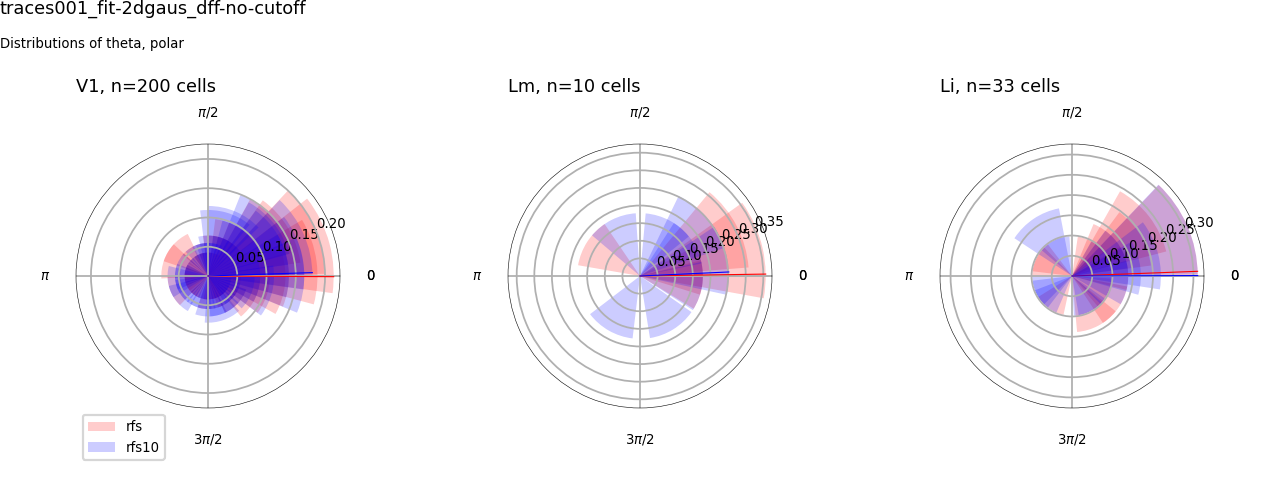

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10 theta_hist__cells_w_both


In [135]:
bins=50
ai = 1
ecolors=['r', 'b']

fig = pl.figure(figsize=(8,3))
for va, vg in cells_w_both.groupby(['visual_area']):
    ai = visual_areas.index(va)
    polar_ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    for ecol, (exp, eg) in zip(ecolors, vg.groupby(['experiment'])):
        thetas = eg['theta'].values
        cmean = spstats.circmean(eg['theta'].values)
        # bin data for our polar histogram
        counts, t_bins = np.histogram(thetas, bins=bins)
        # Normalise counts to compute areas
        area = counts / thetas.size
        # Compute corresponding radii from areas
        radius = (area / np.pi)**.5
        polar_ax.bar(t_bins[:-1], radius, align='edge', color=ecol, alpha=0.2,
                    label=exp)
        polar_ax.plot([0, cmean], [0, max(radius)], color=ecol, lw=0.5)
        # Label angles according to convention
        polar_ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
        polar_ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'])
        polar_ax.set_title('%s, n=%i cells' % (va, len(eg)), loc='left', fontsize=8)
polar_ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of theta, polar')

p3.label_figure(fig, data_id)
figname = 'theta_hist__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [139]:
metric

'theta'

In [140]:
importlib.reload(rfutils)

<module 'rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/rf_utils.py'>

# Combine them meh?

In [141]:
importlib.reload(rfutils)

<module 'rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/rf_utils.py'>

In [142]:
combined_rfs = rfutils.average_rfs_select(rfdata)


In [143]:
combined_rfs.groupby(['visual_area', 'experiment']).count()

datakey  animalid  session  fov_xpos  fov_xpos_pix  \
visual_area experiment                                                        
Li          average_rfs       33        33       33        33            33   
            rfs               16        16       16        16            16   
            rfs10            379       379      379       379           379   
Lm          average_rfs       10        10       10        10            10   
            rfs              349       349      349       349           349   
            rfs10             44        44       44        44            44   
V1          rfs              637       637      637       637           637   

                         fov_ypos  fov_ypos_pix  ml_pos  ap_pos  cell  ...  \
visual_area experiment                                                 ...   
Li          average_rfs        33            33      33      33    33  ...   
            rfs                16            16      16      16    16  ...   
            rfs10             379           379     379     379   379  ...   
Lm          average_rfs        10            10      10      10    10  ...   
            rfs               349           349     349     349   349  ...   
            rfs10              44            44      44      44    44  ...   
V1          rfs               637           637     637     637   637  ...   

                          fx   fy  ratio_xy  theta_c  theta_Mm_deg  \
visual_area experiment                                               
Li          average_rfs   33   33        33       33            33   
            rfs           16   16        16       16            16   
            rfs10        379  379       379      379           379   
Lm          average_rfs   10   10        10       10            10   
            rfs          349  349       349      349           349   
            rfs10         44   44        44       44            44   
V1          rfs          637  637       637      637           637   

                         major_axis  minor_axis  anisotropy  theta_Mm_c  \
visual_area experiment                                                    
Li          average_rfs          33          33          33          33   
            rfs                  16          16          16          16   
            rfs10               379         379         379         379   
Lm          average_rfs          10          10          10          10   
            rfs                 349         349         349         349   
            rfs10                44          44          44          44   
V1          rfs                 637         637         637         637   

                         aniso_index  
visual_area experiment                
Li          average_rfs           33  
            rfs                   16  
            rfs10                379  
Lm          average_rfs           10  
            rfs                  349  
            rfs10                 44  
V1          rfs                  637  

[7 rows x 32 columns]

In [144]:
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
avgrfs = pd.concat(df_)


# Aggr metrics

#### Drop repeats

In [157]:
rf_type='combinedrfs'
aggr_counts = avgrfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()

# Only include rf-5 ----------------------------------------------
best_ = p3.select_best_fovs(aggr_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)
# Check with examples (rf-5):
# ('Lm', '20190506_JC080_fov1') OR ('Lm', '20190603_JC080_fov1')
# ('Lm', '20190506_JC080_fov1') in rf5_keys
# ('Lm', '20190603_JC080_fov1') in rf5_keys #best_rf5[['visual_area', 'datakey']].values

[V1] Animalid does not exist: JC078 


In [158]:
aggdf = pd.concat([rfs_ for (va, dk), rfs_ in avgrfs.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

aggdf.groupby(['visual_area']).count()


,datakey,animalid,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,cell,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,279,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
Lm,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
V1,548,548,548,548,548,548,548,548,548,548,...,548,548,548,548,548,548,548,548,548,548


In [159]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir,  'combined_rfs')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs


In [160]:
final_counts = aggdf.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,279
Lm,241
V1,548


In [161]:
counts_outfile = os.path.join(curr_dst_dir, 'final_counts.csv')
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs/final_counts.csv


In [162]:
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,279
Lm,241
V1,548


In [165]:
final_counts = p3.split_datakey(final_counts)
final_counts.groupby(['visual_area'])['animalid'].count()

visual_area
Li    10
Lm     8
V1    11
Name: animalid, dtype: int64

In [163]:
print("N FOVs:")
print(final_counts.groupby(['visual_area'])['datakey'].count())
m0 = final_counts.groupby(['visual_area'])['cell'].mean().reset_index()
m1 = final_counts.groupby(['visual_area'])['cell'].std().reset_index()
m0['std'] = m1['cell']
m0 = m0.rename(columns={'cell':'mean'})
print(m0)

N FOVs:
visual_area
Li    10
Lm     8
V1    11
Name: datakey, dtype: int64
  visual_area       mean        std
0          Li  27.900000  24.578446
1          Lm  30.125000  24.062048
2          V1  49.818182  43.006553


In [31]:
avgrfs.groupby(['visual_area']).count()

,datakey,animalid,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,cell,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,192,192,192,192,192,192,192,192,192,192,...,192,192,192,192,192,192,192,192,192,192
Lm,107,107,107,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107
V1,147,147,147,147,147,147,147,147,147,147,...,147,147,147,147,147,147,147,147,147,147


In [33]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


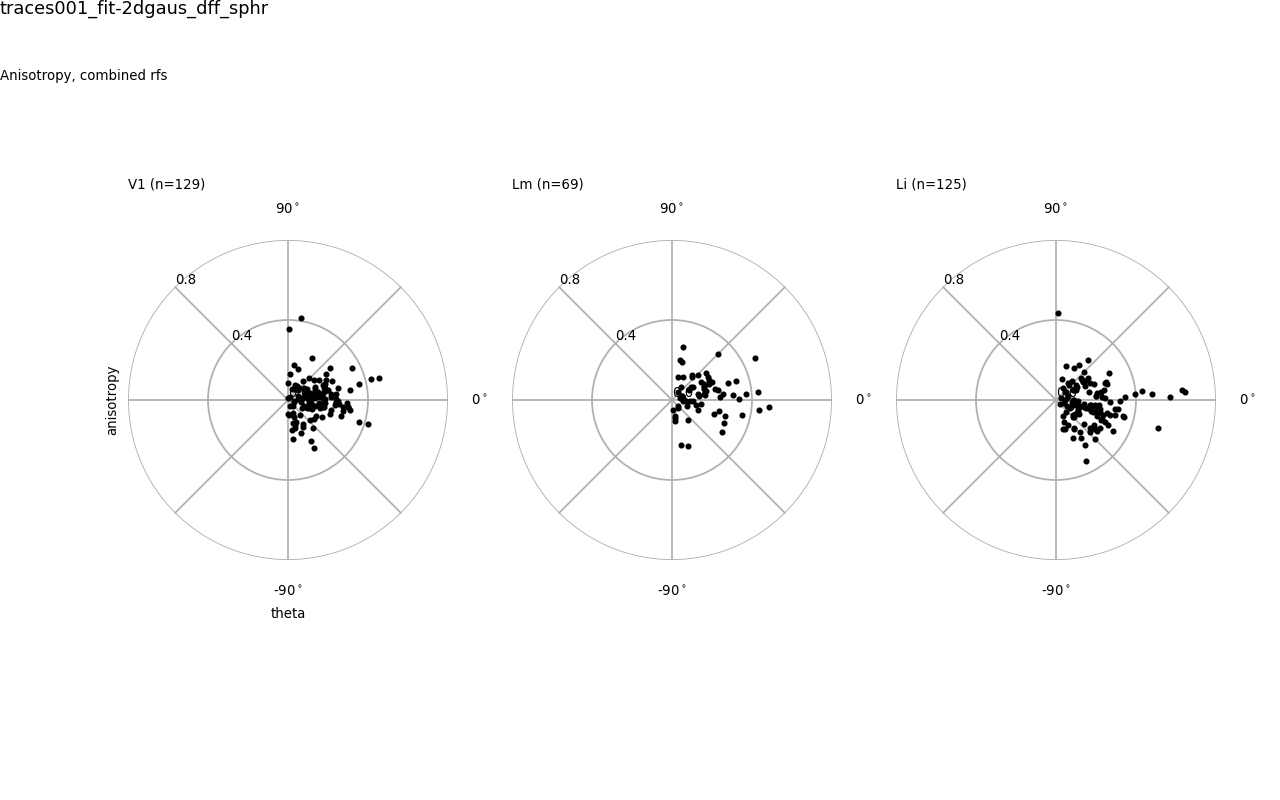

In [36]:
markersize=3
alpha=1
fontsize=6

cmap='spring_r'
metric='anisotropy'
fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(8,5))
for va, vg in aggdf.groupby(['visual_area']):
    ai= visual_areas.index(va)
    ax = axn[ai]
    #ax = fig.add_subplot(2, 3, ai+3+1, projection="polar")
    thetas = vg['theta_Mm_c'].values #% np.pi # all thetas should point the same way
    ratios = vg['anisotropy'].values
    ax.scatter(thetas, ratios, marker='o', s=markersize, c='k', zorder=10000) #c=area_colors[va])
    pplot.adjust_polar_axes(ax)
    if ai!=0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('anisotropy', fontsize=fontsize)
        ax.set_xlabel('theta', fontsize=fontsize)
    ax.set_title('%s (n=%i)' % (va, len(vg)), fontsize=6, loc='left')
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Anisotropy, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'anisotropy_bw.svg'))

In [115]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [116]:
pplot.print_means(aggdf, groupby=['visual_area'], params=plot_metrics,
                 metric='median')

[median]:
  visual_area    std_avg         fx        fy  std_avg_std    fx_std    fy_std
0          Li  12.124802  11.751462  5.739110     2.921622  4.495889  4.278751
1          Lm  11.732919  10.697299  4.371792     3.429262  5.122643  4.096919
2          V1   8.753125   9.603350  2.763351     2.479056  3.785399  2.982599


<IPython.core.display.Javascript object>


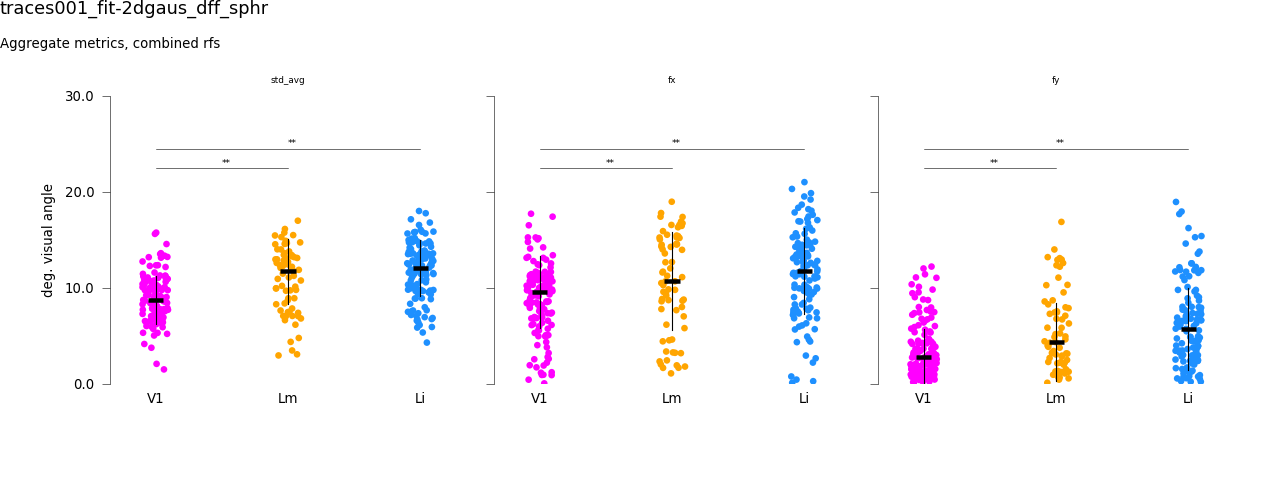

********* [std_avg] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val   U_val   n1   n2
0  V1  Lm    True  5.410513e-06  2726.0  129   69
1  V1  Li    True  3.830791e-14  3602.0  129  125
2  Lm  Li   False  9.172308e-02  3814.0   69  125
****************************
********* [fx] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val   U_val   n1   n2
0  V1  Lm    True  6.499621e-03  3441.5  129   69
1  V1  Li    True  9.979536e-07  5152.0  129  125
2  Lm  Li   False  1.883099e-01  3981.0   69  125
****************************
********* [fy] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val   U_val   n1   n2
0  V1  Lm    True  2.431607e-03  3319.0  129   69
1  V1  Li    True  6.574653e-07  5105.0  129  125
2  Lm  Li   False  1.061229e-01  3845.0   69  125
****************************


In [118]:
y_loc=22.5
plot_metrics = ['std_avg', 'fx', 'fy']

fig, axn = pl.subplots(1,len(plot_metrics),figsize=(8,3), sharey=True)
for ai, metric in enumerate(plot_metrics):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=aggdf, ax=ax,
                 hue='visual_area', palette=area_colors,
                  order=visual_areas, zorder=-1, jitter=True,
                 s=markersize)
    sns.pointplot(x='visual_area', y=metric, data=aggdf, ax=ax,
                 color='k', order=visual_areas, zorder=-1,
                 markers='_', join=False, ci='sd', 
                 errwidth=0.5, estimator=np.median)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    if ai==0:
        ax.set_ylabel('deg. visual angle')
    else:
        ax.set_ylabel('')
    ax.set_title(metric, fontsize=fontsize)
    # stats
    statdf, ax = pplot.plot_mannwhitney(aggdf, metric=metric, ax=ax,
                            multi_comp_test=multi_comp_test, y_loc=y_loc, 
                            offset=2, lw=0.25, fontsize=4)
ax.set_ylim([0, 30])
ax.set_yticks(np.linspace(0, 30, 4))
ax.set_yticklabels(np.linspace(0, 30, 4))
sns.despine(trim=True, offset=8, bottom=True)

pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Aggregate metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'size_metrics.svg'))

In [120]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs'

#### Overlap v. distance

In [119]:
# Calculate overlaps and distance (pairwise)
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# Convert RF fit params to polygon
d_=[]
for (va, dk), rfs_ in aggdf.groupby(['visual_area', 'datakey']):
    rois_ = rfs_['cell'].unique()
    if (va, dk) not in final_rf_keys:
        continue      
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    rfs_.index = rfs_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[overlaps_['poly1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[overlaps_['poly2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    overlaps_['cortical_distance'] = dists
    overlaps_['visual_area'] = va
    overlaps_['datakey'] = dk
    d_.append(overlaps_)
overlaps = pd.concat(d_)
overlaps = overlaps.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})

ValueError: No objects to concatenate

In [39]:
overlaps[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts()

NameError: name 'overlaps' is not defined

In [394]:
del finaldf

NameError: name 'finaldf' is not defined

In [395]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 8

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    overlaps['binned_dist'], bin_edges = pd.qcut(overlaps['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    overlaps['binned_dist'], bin_edges = pd.cut(overlaps['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

binning: eqwidth6


In [396]:
meanf = overlaps.groupby(['visual_area', 'datakey', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


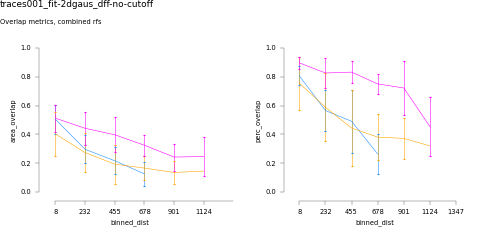

In [397]:
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['area_overlap', 'perc_overlap']):
    sns.lineplot(x='binned_dist', y=metric, data=meanf, ax=ax,
                 hue='visual_area', palette=area_colors, 
                 ci='sd', err_style='bars',
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
    ax.set_xticks(list(range(len(bin_edges))))
    ax.set_xticklabels([round(i) for i in bin_edges])
    ax.set_ylim([0, 1])
    sns.despine(offset=8, trim=True, ax=ax)
    ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Overlap metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'overlap_by_distance.svg'))

<IPython.core.display.Javascript object>


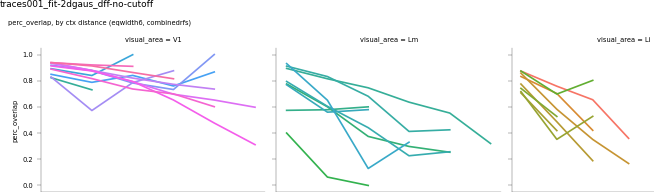

In [398]:
# fig, ax = pl.sublots()
metric = 'perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist' % (metric)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [403]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

# On screen

In [40]:
# Convert to degrees
screen = p3.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [41]:
import retino_utils as retutils

In [82]:
def get_retino_metadata(sdata, 
                    roi_type='pixels', traceid=None,
                    return_errors=False,
                    rootdir='/n/coxfs01/2p-data', 
                    aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    '''
    Gets analysis ID info for ROI-based retino analyses.
    '''
    meta_list=[]
    no_retino=[]
    errors=[]
    for (va, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
        exp_list = [e for e in g['experiment'].values if 'retino' in e] 
        if len(exp_list)==0:
            print('... skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
            continue
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov,\
                                        'retino_*', 'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retinorun = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                try:
                    rid_fpath = glob.glob(os.path.join(retino_dir, 
                                                       'analysisids_*.json'))[0]
                    with open(rid_fpath, 'r') as f:
                        retids = json.load(f)
                    retids = [r for r, res in retids.items() \
                                if res['PARAMS']['roi_type']==roi_type] 
                    assert len(retids)>0, "No ROI-based analyses"
                except AssertionError as e:
                    #print("ERROR")
                    no_retino.append(retino_dir)
                    continue
                except Exception as e:
                    print('ERROR', e)
                    no_retino.append(retino_dir)
                    continue
                for retid in retids: 
                    try:
                        fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                                    'retino_analysis', 'retino_structure', \
                                      'projections_%s.pkl' %  va)
                        assert os.path.exists(fpath), "No projection results (%s, %s, %s)" % (va, dk, retid)
                        meta_list.append(
                            tuple([va, animalid, session, fov, retinorun, retid, fpath]))
                    except Exception as e:
                        print(e)
                        errors.append((retino_dir, retid))
                        continue
            else:
                fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                        'retino_analysis', 'retino_structure', \
                                  'projections_%s.pkl' %  va)
                meta_list.append(
                    tuple([va, animalid, session, fov, retinorun, traceid, fpath]))

    retmeta = pd.DataFrame(meta_list, 
        columns=['visual_area', 'animalid', 'session', \
                 'fov', 'retino_run', 'analysis_id','proj_path'])
    
    if return_errors:
        return retmeta, no_retino, errors
    else:
        return retmeta

# def get_projection_result_paths(retmeta, rootdir='/n/coxfs01/2p-data'):
#     retmeta['proj_path'] = None
#     proj_paths=[]; errors=[]; 
#     no_data=[];success=[];
#     for (va, animalid, session, fov, retinorun), g in \
#             retmeta.groupby(['visual_area', 'animalid', 'session', 'fov', 'retino_run']):
#         skey = '_'.join([va, session, animalid, fov, retinorun])
#         # Load data metainfo
#         retinoid, RETID = retutils.load_retino_analysis_info(animalid, session, fov, run=retinorun)
#         if RETID is None:
#             print('no data, %s' %skey)
#             no_data.append(skey)
#             continue
#         try:
#             fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
#                         'retino_analysis', 'retino_structure', \
#                                   'projections_%s.pkl' %  va)
#             #assert os.path.exists(fpath), "No data: %s" %skey
#             retmeta.loc[g.index, 'proj_path'] = fpath
#             retmeta.loc[g.index, 'analysis_id'] = retinoid
# #             proj_paths.append((va, animalid, session, fov, retinorun, \
# #                                    retinoid, fpath))
#             success.append(skey)
#         except Exception as e:
#             errors.append(skey)
#             continue
#     print("%i of %i paths found" % (len(success), len(retmeta)))
#     return retmeta

In [78]:
import retino_utils as retutils

In [79]:
#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)

pixels_thr-0.003


In [80]:
retmeta = pd.concat([g for (va, dk), g in sdata.groupby(['visual_area', 'datakey'])\
            if ('retino' in g['experiment'].values)])
ret_keys = list((va, dk) for (va, dk) in \
                retmeta[['visual_area', 'datakey']].drop_duplicates().values)

In [83]:
print("Threshold info: %s" % magthr_str)
retino_meta, no_ret, errs = get_retino_metadata(retmeta, roi_type='pixels',
                                                return_errors=True, traceid=None)
# retino_meta = get_projection_result_paths(retino_meta)
print("%i without ROI analysis" % len(no_ret))
for r in no_ret: print('... %s' % r)
print("%i ERR loading projection vectors" % len(errs))
for r in errs: print('... %s' % str(r))
retino_meta = p3.add_datakey(retino_meta)

Threshold info: pixels_thr-0.003
ERROR list index out of range
No projection results (Li, 20190528_JC092_fov1, analysis001)
No projection results (Li, 20190528_JC092_fov1, analysis001)
No projection results (Lm, 20190528_JC092_fov1, analysis001)
No projection results (Lm, 20190528_JC092_fov1, analysis001)
No projection results (Lm, 20190528_JC092_fov1, analysis001)
No projection results (Lm, 20190528_JC092_fov1, analysis001)
No projection results (V1, 20190528_JC092_fov1, analysis001)
1 without ROI analysis
... /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2/retino_analysis
7 ERR loading projection vectors
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC070/20190314/FOV2_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_anal

In [84]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return
import shutil
# Create dir to copy gradient images to, for visual inspection
copy_images = True
dst = os.path.join(curr_dst_dir, 'gradient_maps')
if not os.path.exists(dst):
    os.makedirs(dst)
if copy_images:
    delete_files(dst)
print(dst)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs/gradient_maps


In [85]:

def copy_gradient_maps(fpath, dst, prefix=None):
    src = os.path.split(fpath)[0]
    fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
    fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
    if len(fimpaths)==0:
        fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))
    for fimpath in fimpaths:
        fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
        fn = 'gradients' if 'gradients' in fname else 'unitvec'
        if prefix is None:
            new_fn = fname
        else:
            new_fn ='%s_%s%s' % (prefix, fn, fext)
        shutil.copyfile(fimpath, os.path.join(dst, new_fn))

In [86]:
d_list=[]
cols = ['visual_area', 'datakey', 'retino_run', 'analysis_id', 'proj_path']
for di, (va, dk, retinorun, retinoid, fpath) in enumerate(retino_meta[cols].values):
    if di % 20 == 0 or di==(len(retino_meta)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(retino_meta)))
    with open(fpath, 'rb') as f:
        res = pkl.load(f, encoding='latin1')
    tmpd = res['regr_df'].copy()
    metainfo = {'visual_area': va,  'datakey': dk, 
                'retinorun': retinorun, 'retinoid': retinoid, 'fpath':fpath}
    tmpd = p3.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)
    if copy_images:
        prefix= '%s_%s_%s' % (va, dk, retinorun)
        copy_gradient_maps(fpath, dst, prefix=None)
    
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)
projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

1 of 84 gradient result files loaded.
21 of 84 gradient result files loaded.
41 of 84 gradient result files loaded.
61 of 84 gradient result files loaded.
81 of 84 gradient result files loaded.
84 of 84 gradient result files loaded.


In [87]:
#     with open(fpath, 'rb') as f:
#         res = pkl.load(f, encoding='latin1')
#     tmpd = res['regr_df'].copy()
#     tmpd

In [88]:
#     src = os.path.split(fpath)[0]
#     fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
#     fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
#     if len(fimpaths)==0:
#         fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
#         fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))

In [89]:
# fimpaths

In [90]:
# Drop repeated retino run
best_retino = retutils.select_strongest_retinorun(projection_df)
best_retino['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun \
                            in best_retino[['datakey', 'retinorun']].values]
print(projection_df.shape, best_retino.shape)

(168, 14) (144, 15)


In [91]:
# Select FOVs with BOTH azimuth and elevation passed
retino_r2_thr=0.5
projdf = pd.concat([g for (varea, datakey, retinorun), g \
                in best_retino.groupby(['visual_area', 'datakey', 'retinorun']) \
                if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) \
                and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(best_retino.shape, projdf.shape)

(144, 15) (126, 15)


In [92]:
# Match retino + RF datasets
all_retino_keys = list([tuple(v) for v in projdf[['visual_area', 'datakey']]\
                    .drop_duplicates().values])
rf_df = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey'])\
                  if (va, dk) in all_retino_keys])

all_rf_keys = list([tuple(v) for v in rf_df[['visual_area', 'datakey']]\
                    .drop_duplicates().values])

# Select best RF by # cells (out of the retinos that pass)
final_counts = rf_df.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
print(len(all_rf_keys), len(all_retino_keys))
best_ = p3.select_best_fovs(final_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)

39 63


In [93]:
final_dkeys = [k for k in all_retino_keys if k in final_rf_keys]
print(len(final_dkeys), len(final_rf_keys))

25 25


In [94]:
final_proj = pd.concat([g for (va, dk), g in projdf.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])
final_rfs = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])


In [95]:
final_proj[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,10
Lm,6
V1,9


In [96]:
retinodf = pd.concat([ret_ for (va, dk), ret_ in projdf.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

In [97]:
retinodf[['visual_area', 'datakey', 'retinorun']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey,retinorun
visual_area,,
Li,10,10
Lm,6,6
V1,9,9


In [98]:
aggdf[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,11
Lm,7
V1,9


In [424]:
# final_rfs = aggdf.copy()
# final_proj = retinodf.copy()

In [99]:
def add_transformed_positions(final_rfs, final_proj):
    '''
    Load projection vectors (vectors_VA.pkl) provided by final_proj.
    Apply transform to ROI positions, 
    i.e., convert [ap_pos, ml_pos] --> [ml_proj, ap_proj]
    '''
    f0 = final_rfs.copy()
    f0['ml_proj'] = None
    f0['ap_proj'] = None
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area', 'datakey']):
        ret_ = final_proj[(final_proj['visual_area']==va) 
                        & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("... no pass retino: (%s, %s)" % (va, dk))
            continue
        # Get gradient_results path (vectors_VA.pkl) and load projection vectors
        assert len(ret_['fpath'].unique())==1, "[%s] Found retino path found: %s" \
                                            % (dk, str(ret_['fpath'].unique()))
        fpath = ret_['fpath'].unique()[0]
        gpaths = glob.glob(os.path.join(os.path.split(fpath)[0],
                                        'vectors_%s.pkl' % va))
        gpaths = [f for f in gpaths if '_pixels_thr' not in f] 
        assert len(gpaths)==1, "[%s, %s] Found retino path found: %s" \
                                                    % (dk, exp, str(gpaths))
        with open(gpaths[0], 'rb') as f:
            gresults = pkl.load(f, encoding='latin1')
        # Project FOV coordinates
        f0.loc[rfs_.index, 'ml_proj'] =np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
        f0.loc[rfs_.index, 'ap_proj'] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
    return f0
    

In [100]:
def filter_gradient_fits(final_proj, pass_crit='both', fit_thr=0.5):
    '''
    Filter gradient fits (projections) for retino data.
    '''
    if pass_crit=='both':
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    and (g[g['cond']=='el']['R2'].values>fit_thr))])
    else:
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    or (g[g['cond']=='el']['R2'].values>fit_thr))])
    return filtproj

In [101]:
def calculate_scatter_metrics_split_exp(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (visual_area, datakey, rfname), rfs_ in \
                final_rfs.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:    
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, datakey))
            not_enough_cells_fit.append(datakey)
            continue
        if datakey not in curr_gradients['datakey'].unique():
            print("--- bad gradient, %s" % datakey)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==visual_area) 
                            & (final_proj['datakey']==datakey)].copy()

        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)

            if any(np.isnan(dist_sc)):
                print(visual_area, datakey, r2)
                break
            if any(np.isnan(deg_sc)):
                print(visual_area, datakey, r2, deg_sc)
                break
            tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                               'deg_scatter': deg_sc[keep_ixs],
                               'dist_scatter': dist_sc[keep_ixs],
                               'measured_rf': rf_locs[keep_ixs],
                               'predicted_rf': predicted_rf_locs[keep_ixs],
                               'measured_loc': proj_locs[keep_ixs],
                               'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                               'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                               'axis': [cond for _ in np.arange(0, n_pts)],
                               'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                               'datakey': [datakey for _ in np.arange(0, n_pts)],
                               'rfname': [rfname for _ in np.arange(0, n_pts)]
                         })
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def calculate_scatter_metrics(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area','datakey']):
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, dk))
            not_enough_cells_fit.append(dk)
            continue
        if dk not in final_proj['datakey'].unique():
            print("--- bad gradient, %s" % dk)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==va) 
                            & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("none:: %s" % dk)
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            #print(va, dk, cond, proj_locs)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)
            tmpd=pd.DataFrame({
                       'cell': rf_cell_ids[keep_ixs],
                       'deg_scatter': deg_sc[keep_ixs],
                       'dist_scatter': dist_sc[keep_ixs],
                       'measured_rf': rf_locs[keep_ixs],
                       'predicted_rf': predicted_rf_locs[keep_ixs],
                       'measured_loc': proj_locs[keep_ixs],
                       'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope})
            tmpd['retino_R2'] = r2
            tmpd['axis'] = cond
            tmpd['visual_area'] = va
            tmpd['datakey'] = dk
            tmpd['rfname'] = 'combined'
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def combine_scatter_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='dist_scatter']
    sd1 = scatdf[all_cols].copy().rename(columns={'deg_scatter': 'scatter_val'})
    sd1['scatter_label'] = 'vf_deg'

    all_cols = [k for k in scatdf.columns if k!='deg_scatter']
    sd2 = scatdf[all_cols].copy().rename(columns={'dist_scatter': 'scatter_val'})
    sd2['scatter_label'] = 'ctx_dist'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd


In [102]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.75
retino_pass_crit='both' 
final_rfs = add_transformed_positions(final_rfs, final_proj)
# Filter gradient data
curr_gradients = filter_gradient_fits(final_proj, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf = calculate_scatter_metrics(final_rfs, curr_gradients, min_ncells=5)
print(scatdf.shape)

sd = combine_scatter_metrics(scatdf)
mean_sc = sd.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20190522_JC089_fov1
--- too few cells (min5), 20190528_JC092_fov1
--- bad gradient, 20190607_JC091_fov1
--- bad gradient, 20190609_JC099_fov1
--- too few cells (min5), 20190617_JC099_fov1
--- too few cells (min5), 20191012_JC113_fov1
--- too few cells (min5), 20190504_JC078_fov1
--- too few cells (min5), 20190618_JC097_fov1
--- too few cells (min5), 20190420_JC076_fov1
--- too few cells (min5), 20190517_JC083_fov1
(510, 12)


In [103]:
axis_palette={'az': [0.8]*3, 'el': [0.6]*3}

In [109]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.5
retino_pass_crit='both' 
all_rfs = add_transformed_positions(rf_df, projdf)
# Filter gradient data
all_gradients = filter_gradient_fits(projdf, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf_all = calculate_scatter_metrics(all_rfs, all_gradients, min_ncells=5)
print(scatdf_all.shape)

scat_comb_all = combine_scatter_metrics(scatdf_all)
mean_sc_all = scat_comb_all.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20190522_JC089_fov1
--- too few cells (min5), 20190528_JC092_fov1
--- too few cells (min5), 20190617_JC099_fov1
--- too few cells (min5), 20191012_JC113_fov1
--- too few cells (min5), 20191111_JC120_fov1
--- too few cells (min5), 20190504_JC078_fov1
--- too few cells (min5), 20190509_JC078_fov1
--- too few cells (min5), 20190517_JC083_fov1
--- too few cells (min5), 20190618_JC097_fov1
--- too few cells (min5), 20190420_JC076_fov1
--- too few cells (min5), 20190501_JC076_fov1
--- too few cells (min5), 20190507_JC083_fov1
--- too few cells (min5), 20190517_JC083_fov1
(816, 12)


In [110]:
'20190616_JC097_fov1' in mean_sc_all['datakey'].values

True

In [111]:
s_=[]
for sc, mc in mean_sc.groupby(['scatter_label']):
    s0 = p3.paired_ttests(mc, metric='scatter_val', 
                        c1='az', c2='el', compare_var='axis', 
                        ttest=False)
    s0['scatter_label'] = sc
    s_.append(s0)
statdf = pd.concat(s_)
statdf

,t_stat,p_val,visual_area,scatter_label
0,10.0,0.578125,V1,ctx_dist
1,0.0,0.125000,Lm,ctx_dist
2,2.0,0.375000,Li,ctx_dist
0,0.0,0.015625,V1,vf_deg
1,2.0,0.375000,Lm,vf_deg
2,0.0,0.125000,Li,vf_deg


In [112]:
pplot.print_means(mean_sc, groupby=[ 'scatter_label', 'visual_area'], 
                                  params=['scatter_val'])

MEANS:
  scatter_label visual_area  scatter_val  scatter_val_std
0      ctx_dist          Li   127.559987        74.331579
1      ctx_dist          Lm   152.917694        87.624457
2      ctx_dist          V1   332.043984       115.545159
3        vf_deg          Li     6.417885         3.593359
4        vf_deg          Lm     4.587562         1.097243
5        vf_deg          V1     4.692904         1.886220


<IPython.core.display.Javascript object>


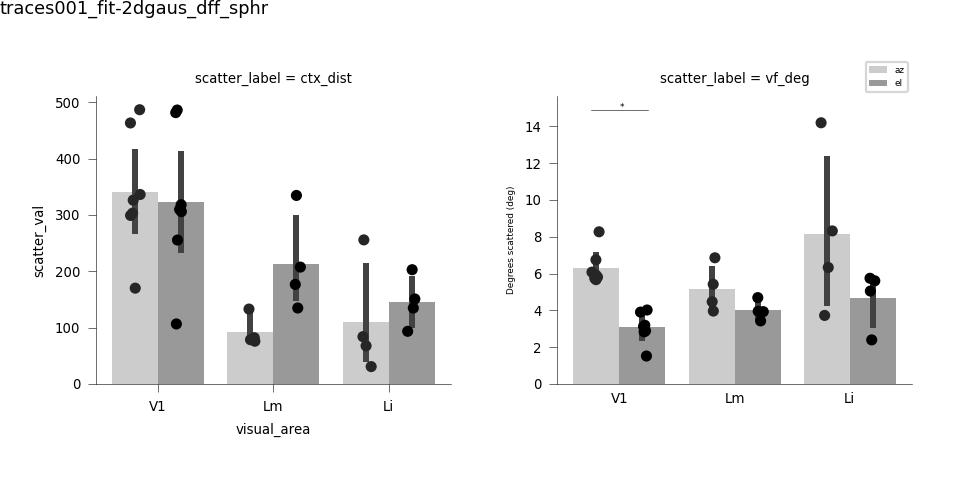

vf_deg 14.895921634006783
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs scatter_dist_and_deg


In [113]:
fg = sns.FacetGrid(mean_sc, col='scatter_label', height=3, aspect=1,sharey=False)
fg.map(sns.barplot, 'visual_area', 'scatter_val', 'axis', 
       order=visual_areas, hue_order=['az', 'el'], palette=axis_palette)
fg.map(sns.stripplot, 'visual_area', 'scatter_val', 'axis', dodge=True, 
       order=visual_areas, hue_order=['az', 'el'], color='k')

bar_length=0.5
offset_frac = 0.25
fontsize=4
lw=0.25
for sl, g in statdf[statdf['p_val']<0.05].groupby(['scatter_label']):
    currax = fg.axes_dict[sl]
    yloc = currax.get_ylim()[-1]
    print(sl, yloc)
    offset = np.mean(np.diff(currax.get_yticks()))*offset_frac
    for va, gg in g.groupby(['visual_area']):
        vi = visual_areas.index(va)
        currax.plot( [vi-(bar_length/2.), vi+(bar_length/2.)], [yloc, yloc], 
                    color='k', lw=lw)
        star_str = '**' if float(gg['p_val'])<0.01 else '*'
        currax.text(vi, yloc, star_str, fontsize=fontsize)
    currax.tick_params(which='both', axis='x', size=0)
    currax.set_xlabel('')
    yl = 'Distance scattered (um)' if sl=='ctx_dist' else 'Degrees scattered (deg)'
    currax.set_ylabel(yl, fontsize=fontsize)
# Legend
fg.axes.flat[1].legend()
lh = pplot.crop_legend_labels(fg.axes.flat[1], n_hues=2, start_ix=2,
                            bbox_to_anchor=(1,1), loc='lower right', fontsize=fontsize)
pl.subplots_adjust(bottom=0.2, top=0.8, right=0.95, left=0.1, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'scatter_dist_and_deg'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [874]:
sc

'vf_deg'

In [863]:
d_=[]
for (sl, va), vg in mean_sc.groupby(['scatter_label', 'visual_area']):
    a_vals = vg[vg['axis']=='az']['scatter_val'].values
    b_vals = vg[vg['axis']=='el']['scatter_val'].values
    diffs = b_vals-a_vals
    df_ = pd.DataFrame({'el_minus_az': diffs})
    df_['visual_area'] = va
    df_['scatter_label'] = sl
    d_.append(df_)
diffs = pd.concat(d_)    

In [864]:
diffs['visual_area'] = diffs['visual_area'].astype('category')

<IPython.core.display.Javascript object>


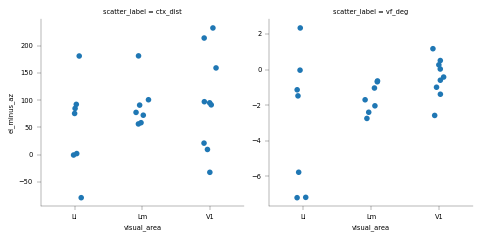

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [865]:

fg=sns.FacetGrid(diffs, col='scatter_label', height=3, sharey=False)
fg.map(sns.stripplot, 'visual_area', 'el_minus_az')

#### Scatter example

In [1568]:
va = 'V1'
dk = '20190522_JC084_fov1' #'20190617_JC097_fov1'
# dk = '20190616_JC097_fov1'

df_= scatdf_all[(scatdf_all.visual_area==va) & (scatdf_all.datakey==dk)].copy()
scatter_cols = ['cell', 'predicted_rf', 'measured_rf', 'predicted_loc', 'measured_loc']
df_[scatter_cols] = df_[scatter_cols].astype(float)


In [1569]:
df_.columns

Index(['cell', 'deg_scatter', 'dist_scatter', 'measured_rf', 'predicted_rf',
       'measured_loc', 'predicted_loc', 'retino_R2', 'axis', 'visual_area',
       'datakey', 'rfname'],
      dtype='object')

In [1573]:
nonnum = ['datakey', 'animalid', 'session', 'experiment', 'visual_area']
numcols = [k for k in final_rfs.columns if k not in nonnum]
final_rfs[numcols] = final_rfs[numcols].astype(float)

In [1574]:
rois_ = rfs_['cell'].unique()
rfs_ = final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_0= final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_.index=rfs_0['cell']
# Get retino gradient
ret_ = final_proj[(final_proj.visual_area==va) & (final_proj.datakey==dk)].copy()

In [1575]:
# Load boot results
session, animalid, fovn = p3.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
eval_results, eval_params = rfutils.load_eval_results(
                                animalid, session, fov, experiment='rfs')
bootdata = eval_results['data']
boot_ = bootdata[bootdata['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]

<IPython.core.display.Javascript object>


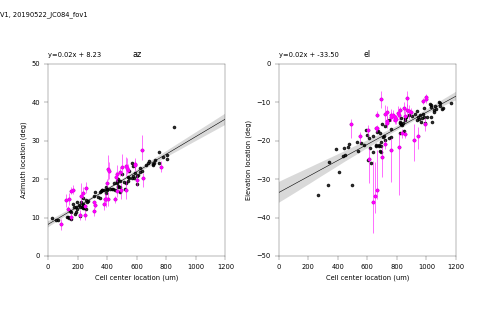

130
130
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs example_scatter_V1_20190522_JC084_fov1


In [1576]:
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(6,4), sharex=True)

for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([-50, 0])
    ax.set_xlim([0, 1200])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    # Get projected cortical position
    ax = rfutils.fit_with_deviants(boot_, cis_, rfs_, xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    currd = df_[df_.axis==cond].copy()
    # should be equivalent to'measured_loc' and 'measured_rf' in SCATTERDF:
#     sns.scatterplot(x='measured_loc', y='measured_rf', data=currd, ax=ax,
#                    color='cyan', alpha=0.5)
        
fig.text(0, 0.95, '%s, %s' % (va, dk))
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'example_scatter_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
